# Draw polar plots for all categories

In [61]:
# See this for the list of valid ones https://pastebin.com/NGzvE0Ky
interesting_categories = [
#    ('VISp', [175, 185, 205], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Slc17a7-IRES2-Cre']),
#    ('VISp', [275, 335, 350], ['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Rorb-IRES2-Cre', 'Scnn1a-Tg3-Cre']),
#    ('VISp', [375, 390, 400], ['Emx1-IRES-Cre', 'Slc17a7-IRES2-Cre', 'Fezf2-CreER', 'Rbp4-Cre_KL100', 'Tlx3-Cre_PL56'])
     ('VISp', [550], ['Ntsr1-Cre_GN220'])
]
    
dsi_dg_threshold = 0.5

In [62]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'
    
import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
from utils.data_wrappers import *
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)

In [63]:
get_one_category_polar_data_cache = {}

In [64]:
def get_avg_cell_polar_in_experiment(boc, ec_id, exp_id, cells):
    """
    Get the polar data for all cells in this experiment, then average them out to get a single polar data.
    """
    in_category_cells = cells[cells.experiment_container_id == ec_id]
    dg_response_filter = get_dg_response_filter_from_saskia()
    filtered_cells = get_filtered_cells(in_category_cells, dg_response_filter)
    filtered_cells = filtered_cells[filtered_cells.dsi_dg > dsi_dg_threshold]
    print ("In this experiment, we have", len(in_category_cells),
           "cells, but after filtering, we have", len(filtered_cells), "cells")
    
    thetas = []
    rs = []
    cell_ids = []
    for ii, row in filtered_cells.iterrows():
        cell_specimen_id = row.cell_specimen_id
        pref_tf = row.pref_tf
        one_cell_polar_data_dict = get_avg_normalized_response(
            boc=boc,
            session_id=exp_id,
            cell_specimen_id = cell_specimen_id,
            temporal_frequency=pref_tf)
        if one_cell_polar_data_dict is None:
            continue
        theta, r = convert_polar_dict_to_arrays(one_cell_polar_data_dict)
        thetas.append(theta)
        rs.append(r)
        cell_ids.append(cell_specimen_id)
        
    print ("In this experiment, we have", len(in_category_cells),
           "cells, but after filtering and removing negative mean dffs, we have", len(thetas), "cells")
    if len(thetas) == 0:
        return None, None, None
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    return agg_theta, agg_r, len(thetas)

In [65]:
def get_one_category_polar_data(boc, targeted_structure, imaging_depths, cre_lines):
    cache_key = (targeted_structure, tuple(imaging_depths), tuple(cre_lines))
    if cache_key in get_one_category_polar_data_cache:
        return get_one_category_polar_data_cache[cache_key]
    
    exps = boc.get_ophys_experiments(stimuli=[stim_info.DRIFTING_GRATINGS],
        targeted_structures = [targeted_structure],
        imaging_depths = imaging_depths,
        cre_lines = cre_lines)
    if len(exps) == 0:
        return None, None, None, None
    print ("There are", len(exps), "experiments for ", targeted_structure, imaging_depths, cre_lines)
    
    thetas = []
    rs = []
    total_num_cells = 0
    for exp in exps:
        e_id = exp['id']
        ec_id = exp['experiment_container_id']
        print("Processing experiment", e_id)
        theta, r, num_cells = get_avg_cell_polar_in_experiment(boc, ec_id, e_id, cells)
        if theta is None or len(theta) == 0:
            continue
        thetas.append(theta)
        rs.append(r)
        total_num_cells += num_cells
        
    agg_theta, agg_r = get_avg_polar(thetas, rs)
    
    if len(thetas) == 0:
        agg_theta, agg_r, thetas, rs, total_num_cells= None, None, None, None, None
    
    get_one_category_polar_data_cache[cache_key] = (agg_theta, agg_r, thetas, rs, total_num_cells)
    return get_one_category_polar_data_cache[cache_key]


There are 6 experiments for  VISp [550] ['Ntsr1-Cre_GN220']
Processing experiment 665722301
In this experiment, we have 28 cells, but after filtering, we have 3 cells
In this experiment, we have 28 cells, but after filtering and removing negative mean dffs, we have 3 cells
Processing experiment 689388034
In this experiment, we have 214 cells, but after filtering, we have 39 cells
In this experiment, we have 214 cells, but after filtering and removing negative mean dffs, we have 39 cells
Processing experiment 604145810
In this experiment, we have 65 cells, but after filtering, we have 11 cells
In this experiment, we have 65 cells, but after filtering and removing negative mean dffs, we have 11 cells
Processing experiment 603576132
In this experiment, we have 163 cells, but after filtering, we have 41 cells
In this experiment, we have 163 cells, but after filtering and removing negative mean dffs, we have 41 cells
Processing experiment 645086975
In this experiment, we have 69 cells, but 

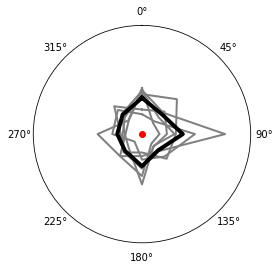

In [66]:
import warnings; warnings.simplefilter('ignore');
for targeted_structure, imaging_depths, cre_lines in interesting_categories:
    agg_theta, agg_r, thetas, rs, num_cells = get_one_category_polar_data(
        boc,
        targeted_structure,
        imaging_depths,
        cre_lines)
    if agg_theta is None:
        continue
    print(targeted_structure, imaging_depths, cre_lines, "#Experiments: ", len(thetas), "#Cells:", num_cells)
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(polar=True))
    polar_plot_population(ax=ax,
        bold_theta = agg_theta,
        bold_r = agg_r,
        grey_thetas = thetas, 
        grey_rs = rs)
    plt.show()